# Detecting sample in IMDB dataset that breaks training

In [1]:
import torch
from fastai.text.all import *

%matplotlib inline

In [2]:
dataset_path = untar_data(URLs.IMDB)
dataset_path.ls()

(#7) [Path('/home/ubuntu/.fastai/data/imdb/unsup'),Path('/home/ubuntu/.fastai/data/imdb/test'),Path('/home/ubuntu/.fastai/data/imdb/README'),Path('/home/ubuntu/.fastai/data/imdb/tmp_lm'),Path('/home/ubuntu/.fastai/data/imdb/tmp_clas'),Path('/home/ubuntu/.fastai/data/imdb/imdb.vocab'),Path('/home/ubuntu/.fastai/data/imdb/train')]

In [158]:
def limit_samples(ds_files, max_samples = 1000):
    """
    limits number of samples per class
    """
    filtered_files = []
    pos = 0
    neg = 0
    for f in dataset_files:
        parent = parent_label(f)
        match parent:
            case 'pos':
                pos += 1
                if pos <= max_samples:
                    filtered_files.append(f)
            case 'neg':
                neg += 1
                if neg <= max_samples:
                    filtered_files.append(f)
            case _:
                print(f'broken class: {f}')
    print(len(filtered_files))
    return L(filtered_files)

tok_rules = [
    lowercase,
    fix_html,
    spec_add_spaces,
    rm_useless_spaces,
]
x_tfms = [
    Tokenizer.from_folder(dataset_path, tok=TokenizeWithRules(WordTokenizer(), tok_rules), rules=[]),
    Numericalize()
]
y_tfms = [
    parent_label,
    Categorize()
]

if False:
    # attempt to find broken training sample by limiting samples per class
    dataset_files = get_text_files(dataset_path, folders=['train'])
    dataset_files = limit_samples(dataset_files, 8_000)
    splitter = TrainTestSplitter(test_size=0.2, random_state=42)(dataset_files)
else:
    dataset_files = get_text_files(dataset_path, folders=['train'])
    # narrow search range:
    # dataset_files = dataset_files[:17_000] + dataset_files[19_000:]  
    # dataset_files = dataset_files[17_000:19_000]
    splitter = TrainTestSplitter(test_size=0.2, random_state=42)(dataset_files)
    print("Train set size:", len(splitter[0]), "Val set size:", len(splitter[1]))

val_split = splitter[1]
val_split.sort()
# # for i in val_split:
# #     display(i)
# # display(val_split)

test_split = splitter[0]
test_split.sort()
# # for i in test_split:
# #     display(i)

# display broken samples and their files:
display(test_split[1230:1232])
display(dataset_files[*test_split[1230:1232]])

# dsets = Datasets(dataset_files, [x_tfms, y_tfms], splits=splitter)
dsets = Datasets(dataset_files, [x_tfms, y_tfms], splits=(test_split[1230:1232], val_split))
    
bs = 2
dloaders = dsets.dataloaders(dl_type=SortedDL, bs=bs, val_bs=bs, before_batch=pad_input, drop_last=True, val_drop_last=True, verbose=True)
opt_func = partial(Adam, wd=0.1)
learner = text_classifier_learner(
    dloaders,
    AWD_LSTM,
    metrics=[accuracy],
    drop_mult=0.5,
    opt_func=opt_func
)
learner = learner.to_fp16()
learner.model = learner.model.to('cuda')
learner.lr_find()

Train set size: 19999 Val set size: 5000


In [159]:
# check files manually for missing content, failing tokenization/numericalization and wrong labels
# (no results)
tokenizer = x_tfms[0]
num = x_tfms[1]

def validate_files():
    for f in dataset_files:
        with open(f) as txt:
            t = txt.read()
            tokenized = tokenizer(t)
        s = len(t)
        if s == 0:
            display(f'{f} = {s}')
        
        l = len(tokenized)
        if l == 0:
            display(f'{f} = {l}')
    
        p = f.parent.name
        if p != 'pos':
            print(f'{f} < {p}')
    
        n = num(tokenized)
        if n.shape[0] < 10:
            display(f'{f} -> {n}')
# validate_files()

In [160]:
bs = 256
dloaders = dsets.dataloaders(dl_type=SortedDL, bs=bs, val_bs=bs, before_batch=pad_input, drop_last=True, val_drop_last=True, verbose=True)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: Pad_Input
Setting up after_batch: Pipeline: 


In [161]:
opt_func = partial(Adam, wd=0.1)
learner = text_classifier_learner(
    dloaders,
    AWD_LSTM,
    metrics=[accuracy],
    drop_mult=0.5,
    opt_func=opt_func
)
learner = learner.to_fp16()
learner.model = learner.model.to('cuda')

In [162]:
import math

# check manually for nan in predictions:
for i, b in enumerate(dloaders.train):
    x, y = b
    preds = learner.model(x)
    
    p = preds[0][0][0].item()
    if math.isnan(p): 
        display(f'({i}): {p}')
    break

SuggestedLRs(valley=0.02754228748381138)

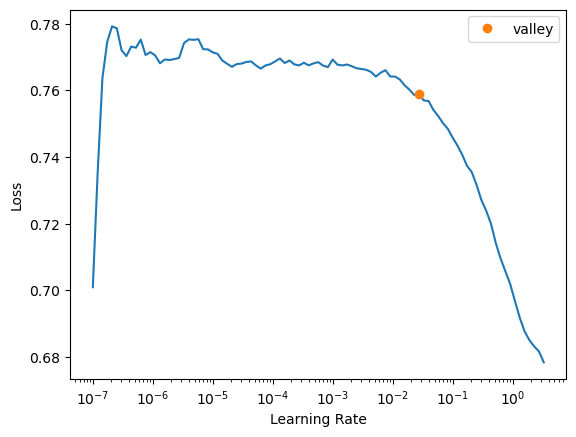

In [163]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(10, 0.027, moms=(0.8, 0.7, 0.8))

In [ ]:
learner.recorder.plot_loss()